# Exploration of Stanford Sentiment Treebank dataset
https://nlp.stanford.edu/sentiment/code.html

In [19]:
import itertools
import os
import sys
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from pandas import option_context

In [20]:
data_path = 'data/stanfordSentimentTreebank'
text_path = os.path.join(data_path, 'datasetSentences.txt')
sentiment_path = os.path.join(data_path, 'sentiment_labels.txt')
split_path = os.path.join(data_path, 'datasetSplit.txt')
dictionary_path = os.path.join(data_path, 'dictionary.txt')


text_df = pd.read_csv(text_path, sep='\t')
    
sentiment_df = pd.read_csv(sentiment_path, sep='|')

split_df = pd.read_csv(split_path, sep=',')

split_df = pd.read_csv(split_path, sep=',')

dictionary_df = pd.read_csv(dictionary_path, sep='|', header=None)
dictionary_df.columns = ['phrase', 'id']

In [21]:
id_to_sentiment = {id_: sentiment for id_, sentiment in zip(sentiment_df['phrase ids'], sentiment_df['sentiment values'])}
phrase_to_sentiment = {sentence: id_to_sentiment[id_] for sentence, id_ in zip(dictionary_df['phrase'], dictionary_df['id'])}
sentiments = [phrase_to_sentiment.get(phrase) for phrase in text_df['sentence']]
text_df['sentiment'] = sentiments
text_df = pd.merge(text_df, split_df, on='sentence_index')

In [22]:
text_df.head()

,sentence_index,sentence,sentiment,splitset_label
0,1,The Rock is destined to be the 21st Century 's...,0.69444,1
1,2,The gorgeously elaborate continuation of `` Th...,0.83333,1
2,3,Effective but too-tepid biopic,0.51389,2
3,4,If you sometimes like to go to the movies to h...,0.73611,2
4,5,"Emerges as something rare , an issue movie tha...",0.86111,2


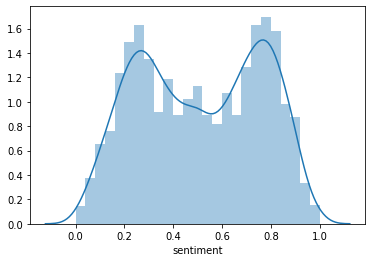

In [23]:
sns.distplot(text_df['sentiment']);

In [24]:
neutral = text_df[(text_df['sentiment'] < 0.52) & (text_df['sentiment'] > 0.48) & (text_df['sentiment'] != 0.5)]
with option_context('display.max_colwidth', 400):
    display(neutral.head(10))

,sentence_index,sentence,sentiment,splitset_label
2,3,Effective but too-tepid biopic,0.51389,2
78,79,"The appearance of Treebeard and Gollum 's expanded role will either have you loving what you 're seeing , or rolling your eyes .",0.51389,2
232,233,"Though this film can be clumsy , its ambitions are equally -- and admirably -- uncommercial .",0.48611,2
260,261,"The additional storyline is interesting and entertaining , but it does n't have the same magical quality as the beginning of the story .",0.48611,2
278,279,"Using his audience as a figurative port-of-call , Dong pulls his even-handed ideological ship to their dock for unloading , before he continues his longer journey still ahead .",0.51389,2
294,295,"Ultimately , the message of Trouble Every Day seems to be that all sexual desire disrupts life 's stasis .",0.51389,2
398,399,... the gentle melding of drama and comedy makes `` What Time Is It There ? '',0.48611,2
431,432,"Chalk it up to my adoration for both De Niro and Murphy , but I had a pretty good time with this movie - despite its myriad flaws .",0.51389,2
467,468,"` Tadpole ' was one of the films so declared this year , but it 's really more of The Next Pretty Good Thing .",0.51389,1
523,524,"It 's often infuriatingly glib and posturing , and yet it has been made with great evident care and manages to deliver up the man in a way to arouse further curiosity in even the most unknowing viewer .",0.48611,2


In [25]:
x = 0.7
with option_context('display.max_colwidth', 400):
    display(text_df[text_df['sentiment'] > x].sort_values('sentiment').head(10))

,sentence_index,sentence,sentiment,splitset_label
1494,1495,"Immersing us in the endlessly inventive , fiercely competitive world of hip-hop DJs , the project is sensational and revelatory , even if scratching makes you itch .",0.70833,3
3428,3429,It is an unstinting look at a collaboration between damaged people that may or may not qual,0.70833,1
4247,4248,Aniston has at last decisively broken with her Friends image in an independent film of satiric fire and emotional turmoil .,0.70833,1
11557,11558,"` Possession , ' based on the book by A.S. Byatt , demands that LaBute deal with the subject of love head-on ; trading in his cynicism for reverence and a little wit",0.70833,1
5030,5031,The film is delicately narrated by Martin Landau and directed with sensitivity and skill by Dana Janklowicz-Mann .,0.70833,1
4117,4118,"It excels because , unlike so many other Hollywood movies of its ilk , it offers hope .",0.70833,1
4364,4365,This is a film that manages to find greatness in the hue of its drastic iconography .,0.70833,1
219,220,"A somewhat crudely constructed but gripping , questing look at a person so racked with self-loathing , he becomes an enemy to his own race .",0.70833,2
4765,4766,"Although shot with little style , Skins is heartfelt and achingly real .",0.70833,1
3392,3393,Foster breathes life into a roll that could have otherwise been bland and run of the mill .,0.70833,1


I decided to set thresholds of $0.3$ and $0.7$ for negative and positive sentiment respectively. That leaves us with 6515 examples out of initial 11855, with 53% positive texts.

In [26]:
df = text_df[(text_df['sentiment'] > 0.7) | (text_df['sentiment'] < 0.3)].copy()

In [27]:
len(df), len(text_df)

(6515, 11855)

In [28]:
df['label'] = [1 if sentiment > 0.5 else 0 for sentiment in df['sentiment']]

In [29]:
(df['label'] == 1).mean()

0.5318495778971604

In [30]:
df['train'] = df['splitset_label'] == 1
df['dev'] = df['splitset_label'] == 3
df['test'] = df['splitset_label'] == 2

In [31]:
df.head()

,sentence_index,sentence,sentiment,splitset_label,label,train,dev,test
1,2,The gorgeously elaborate continuation of `` Th...,0.83333,1,1,True,False,False
3,4,If you sometimes like to go to the movies to h...,0.73611,2,1,False,False,True
4,5,"Emerges as something rare , an issue movie tha...",0.86111,2,1,False,False,True
6,7,Offers that rare combination of entertainment ...,0.83333,2,1,False,False,True
8,9,Steers turns in a snappy screenplay that curls...,0.77778,2,1,False,False,True


## Classification on yelp tokenization
At first, we will use tokenizer from yelp dataset.

In [33]:
from style_transfer import Tokenizer, get_dataset, translate
sys.path.append('../deep-latent-sequence-model/src')
from data_utils import DataUtil
os.chdir('/home/przemyslaw/text-style-transfer/deep-latent-sequence-model')

model_dir = '../deep-latent-sequence-model/outputs_yelp_/yelp_wd0.0_wb0.0_ws0.0_an3_pool5_klw0.1_lr0.001_t0.01_lm_bt_hard_avglen'
model_path = os.path.join(model_dir, 'model.pt')
model = torch.load(model_path).eval()

tokenizer = Tokenizer(model.data.src_i2w)
os.chdir('/home/przemyslaw/text-style-transfer/mgr-code')

In [64]:
MAX_LEN = 60
x_train = [tokenizer.tokenize(text) for text in df[df['train']]['sentence'].values]
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN, padding='pre')
y_train = df[df['train']]['label'].values

x_dev = [tokenizer.tokenize(text) for text in df[df['dev']]['sentence'].values]
x_dev = tf.keras.preprocessing.sequence.pad_sequences(x_dev, maxlen=MAX_LEN, padding='pre')
y_dev = df[df['dev']]['label'].values

In [35]:
# Building the CNN Model
sentiment_model = tf.keras.Sequential()
sentiment_model.add(tf.keras.layers.Embedding(len(tokenizer), 32, input_length=MAX_LEN))
sentiment_model.add(tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
sentiment_model.add(tf.keras.layers.MaxPooling1D())
sentiment_model.add(tf.keras.layers.Flatten())
sentiment_model.add(tf.keras.layers.Dense(250, activation='relu'))
sentiment_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [22]:
sentiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [23]:
history = sentiment_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), batch_size=64, epochs=5, shuffle=True)

Epoch 1/5
73/73 [==============================] - 1s 11ms/step - loss: 0.6904 - accuracy: 0.5281 - auc: 0.5193 - val_loss: 0.6797 - val_accuracy: 0.5275 - val_auc: 0.7238
Epoch 2/5
73/73 [==============================] - 0s 6ms/step - loss: 0.5325 - accuracy: 0.7255 - auc: 0.8224 - val_loss: 0.4283 - val_accuracy: 0.7947 - val_auc: 0.8846
Epoch 3/5
73/73 [==============================] - 1s 8ms/step - loss: 0.2542 - accuracy: 0.8975 - auc: 0.9614 - val_loss: 0.4524 - val_accuracy: 0.7780 - val_auc: 0.8813
Epoch 4/5
73/73 [==============================] - 1s 8ms/step - loss: 0.1183 - accuracy: 0.9601 - auc: 0.9926 - val_loss: 0.5352 - val_accuracy: 0.7863 - val_auc: 0.8779
Epoch 5/5
73/73 [==============================] - 1s 8ms/step - loss: 0.0586 - accuracy: 0.9825 - auc: 0.9985 - val_loss: 0.6530 - val_accuracy: 0.7846 - val_auc: 0.8723


In [24]:
lens = [sum([x != 0 for x in s]) for s in x_train]

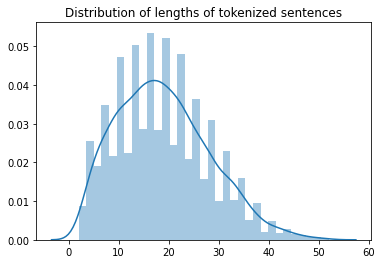

In [25]:
sns.distplot(lens)
plt.title('Distribution of lengths of tokenized sentences');

In [26]:
unks = [sum([x == 1 for x in s]) for s in x_train]
print(sum(unks) / sum(lens))

0.1578394786994876


In [27]:
len(tokenizer)

9653

16% of words in the train data is unknown, similarily for dev data. For yelp data, we have it equal to zero for both train and dev sets. It is suprising to me, that it's zero for dev set, that may mean, that 1) authors trained tokenizer on the whole dataset or 2) the vocabulary is not diverse at all. Vocabulary consists of 9653 words.

In [28]:
text = df['sentence'].values[0]
text

"The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth ."

In [29]:
tokenizer.decode(tokenizer.tokenize(text))

"the <unk> <unk> <unk> of `` the lord of the rings '' <unk> is so huge that a <unk> of words can not <unk> describe <unk> peter jackson 's expanded vision of <unk> . <unk> 's <unk> ."

## Measuring performance on yelp sentiment model

In [65]:
yelp_sentiment_model = tf.keras.models.load_model('models/yelp_sentiment_model')

In [68]:
yelp_sentiment_model.evaluate(x_dev, y_dev)

19/19 [==============================] - 0s 3ms/step - loss: 0.7810 - accuracy: 0.7713 - auc: 0.8537


[0.7809592485427856, 0.7712854743003845, 0.8536867499351501]

In [69]:
predictions = yelp_sentiment_model.predict(x_dev)[:, 0]

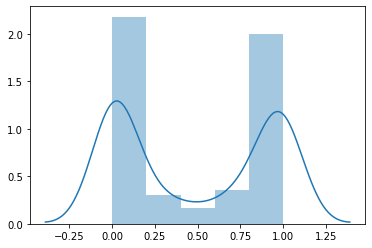

In [70]:
sns.distplot(predictions)

I am very suprised to see, that the performance of the Yelp-trained model (77.13% accuracy) is only slightly worse than model trained on the new dataset (79.47% accuracy).